In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
import catboost as cat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
#import shap
#from catboost import CatBoostRegressor
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import KFold

def str_to_list(x):
    return eval(x) if x and x != '#N/A' else []

list_cols = [
    'genres',
    'belongs_to_collection',
    'production_companies',
    'production_countries',
    'spoken_languages',
    'Keywords',
    'cast',
    'crew'
]

io_params = {
    'index_col': 'id',
    'converters': {col: str_to_list for col in list_cols}
}
#We can drop the id as the id will have no correlation to the revenue
train = pd.read_csv('train.csv', **io_params).drop(["imdb_id", "revenue"], axis=1)
test = pd.read_csv('test.csv', **io_params).drop("imdb_id", axis=1)
target = pd.read_csv('train.csv', **io_params).revenue.values
pro_train = pd.DataFrame()
pro_test = pd.DataFrame()
train.head()

,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
id,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
3,[],3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
4,[],1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
5,[],0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,[],"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de..."


In [2]:

train["id"] = train.index
test["id"] = test.index

train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

test.drop("id",axis=1,inplace=True)
train.drop("id",axis=1,inplace=True)

# Revenue

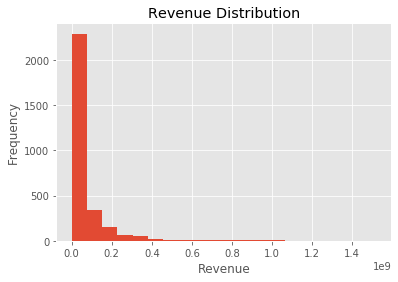

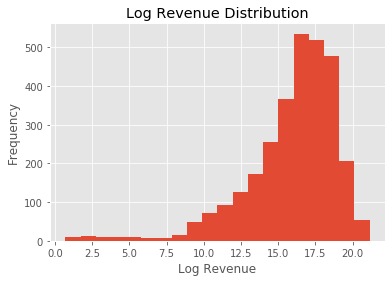

In [3]:
# Lets check the distributions of the revenue
plt.hist(target, bins=20)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()
plt.hist(np.log1p(target), bins=20)
plt.title("Log Revenue Distribution")
plt.xlabel("Log Revenue")
plt.ylabel("Frequency")
plt.show()

In [4]:
# The log revenue has a more normal distribution so we will use it as our target
target = np.log1p(target)

# Value counts

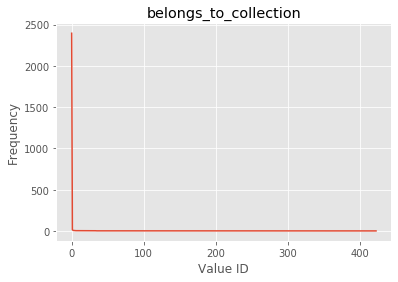

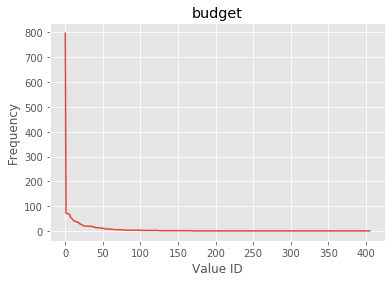

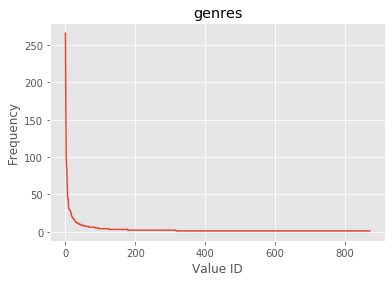

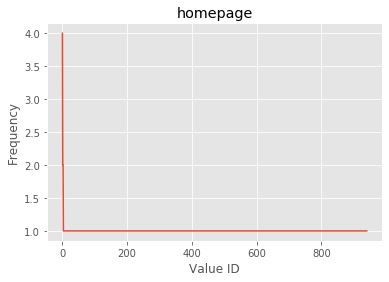

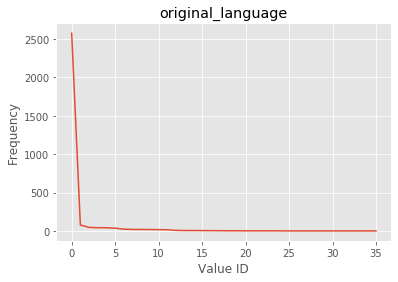

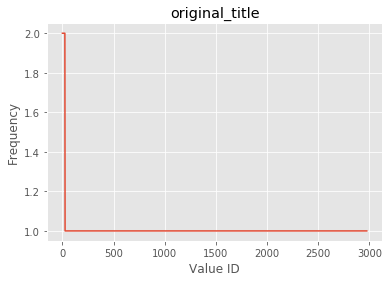

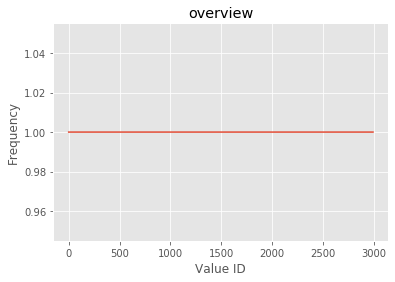

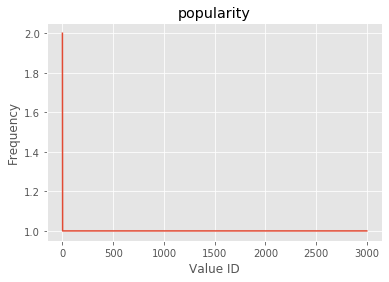

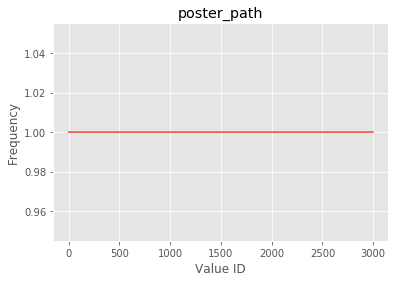

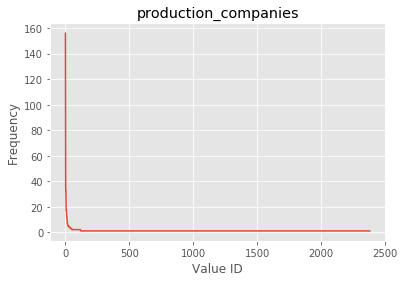

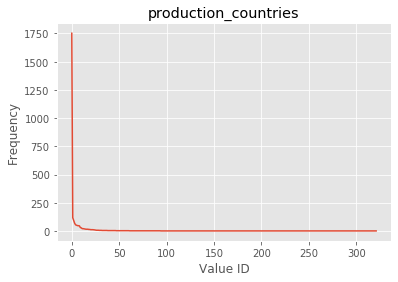

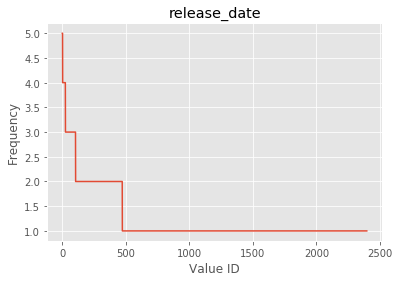

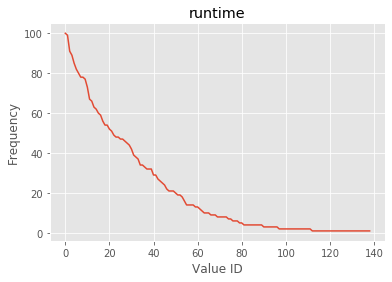

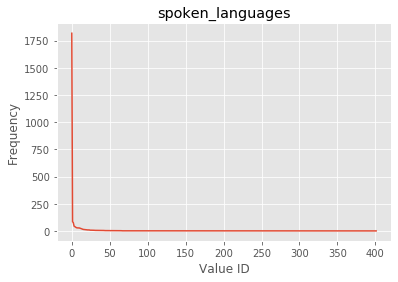

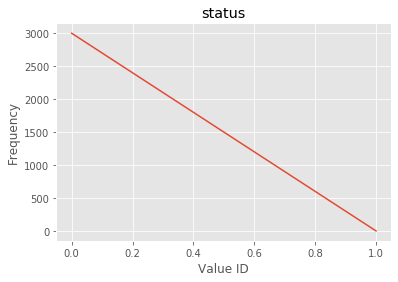

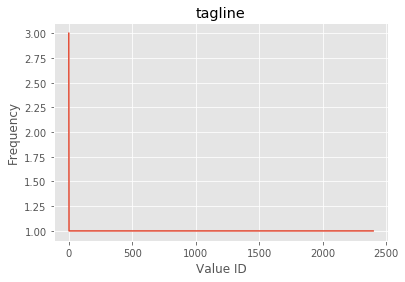

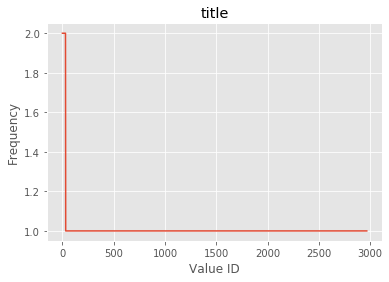

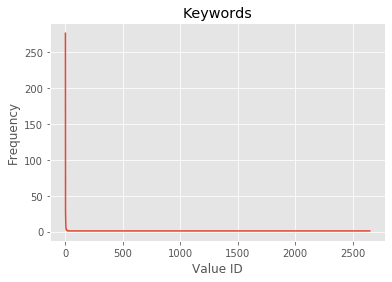

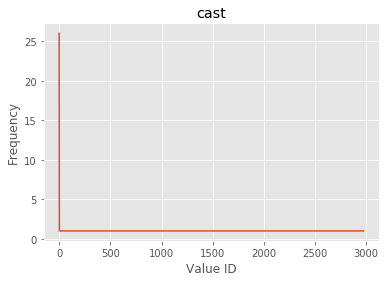

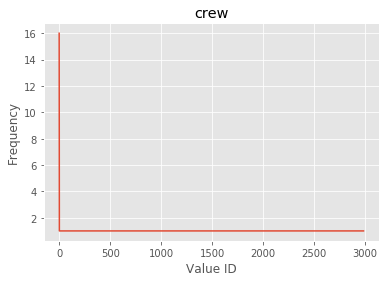

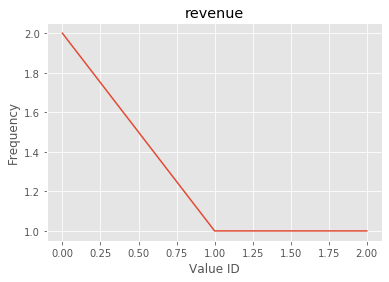

<Figure size 432x288 with 0 Axes>

In [5]:
#A very rough way to see how many values and their distributions in teh columns
for col in train.columns:
    plt.plot(list(range(len(train[col].value_counts()))), train[col].value_counts().values)
    plt.title(col)
    plt.xlabel("Value ID")
    plt.ylabel("Frequency")
    plt.show()
    plt.clf()

# Belongs to Collection

In [6]:
train["belongs_to_collection"].value_counts()[0:5]

[]                                                                                                                                                                         2396
[{'id': 645, 'name': 'James Bond Collection', 'poster_path': '/HORpg5CSkmeQlAolx3bKMrKgfi.jpg', 'backdrop_path': '/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg'}]                        16
[{'id': 9735, 'name': 'Friday the 13th Collection', 'poster_path': '/uobgqpLQff9WvxGKE2OSvXv1RHm.jpg', 'backdrop_path': '/c7pMKwv5NzIN6N3KM4L8fYMTtPw.jpg'}]                  7
[{'id': 937, 'name': 'The Pink Panther (Original) Collection', 'poster_path': '/xu6gZ0zGUSR8SC2QLKFaUrX2niM.jpg', 'backdrop_path': '/6KE7AguGR3UqwUn5RkzkoBc3MLy.jpg'}]       6
[{'id': 34055, 'name': 'Pokémon Collection', 'poster_path': '/j5te0YNZAMXDBnsqTUDKIBEt8iu.jpg', 'backdrop_path': '/iGoYKA0TFfgSoZpG2u5viTJMGfK.jpg'}]                         5
Name: belongs_to_collection, dtype: int64

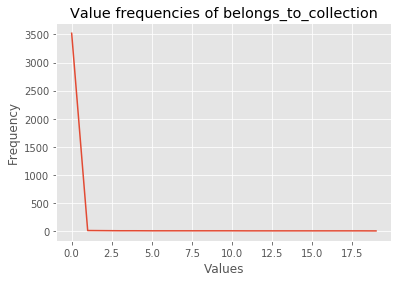

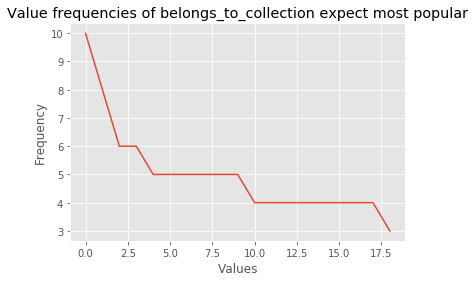

In [7]:
# Lets see how the value counts are distributed in the collections
collections = []
for i in test["belongs_to_collection"]:
    if len(i) > 0:
        for s in range(len(i)):
            collections.append(i[s]["id"] )
    else:
        collections.append(-1)

plt.plot(pd.Series(collections).value_counts().values[0:20])
plt.title("Value frequencies of belongs_to_collection")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()
plt.plot(pd.Series(collections).value_counts().values[1:20])
plt.title("Value frequencies of belongs_to_collection expect most popular")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

In [8]:
# a function to make dummie variables
# the catagories may or may not be be all possible catagories so the function may sometimes
# produce dummies that fall to the dummy variable trap
def make_dummies(series, labels):
    dummies = np.zeros((len(series), len(labels)))
    for element in range(len(series)):
        temp = []
        for label in range(len(labels)):
            for value in range(len(series[element])):
                if series[element][value] == labels[label]:
                    dummies[element][label] = 1
                else:
                    dummies[element][label] = 0
       
    return dummies.astype(np.int32)

In [9]:
# Method to add an array to a dictionary
def add_array_to_dict(arr, dct, cols):
    for i in range(arr.shape[1]):
            dct[cols[i]] = arr[:,i]
    

In [10]:
# functino to turn a column from test and train data and add one hot encoded versions of the data 
# into the new test and train
def dict_to_onehot_df(test, train, newtest, newtrain, tag, col, top=15):
    data = []
    vals = 0
    
    cats = []
    for i in list(train[col])+list(test[col]):
        if len(i) < 1:
            cats.append("No " + tag)
        for s in range(len(i)):
            cats.append(i[s][tag])
    lcats = pd.Series(list(cats)).value_counts().index[:top]      

    for i in train[col]:
        if len(i) == 0:
            data.append(["No " + tag])
        else:
            temp = []
            for s in range(len(i)):
                temp.append(i[s][tag])  
            data.append(temp)
    
    add_array_to_dict(make_dummies(data, lcats), newtrain, lcats)

    data = []
    for i in test[col]:
        if len(i) == 0:
            data.append(["No " + tag])
        else:
            temp = []
            for s in range(len(i)):
                temp.append(i[s][tag])
            data.append(temp)
    print(lcats)
    add_array_to_dict(make_dummies(data, lcats), newtest, lcats)
dict_to_onehot_df(test, train, pro_test, pro_train, 'name', "belongs_to_collection", 18)   

Index(['No name', 'James Bond Collection', 'Friday the 13th Collection',
       'Pokémon Collection', 'Harry Potter Collection', 'Star Wars Collection',
       'Halloween Collection', 'A Nightmare on Elm Street Collection',
       'The Fast and the Furious Collection',
       'The Pink Panther (Original) Collection', 'Saw Collection',
       'Police Academy Collection', 'Rocky Collection',
       'Resident Evil Collection', 'The Muppet Collection',
       'Paranormal Activity Collection', 'X-Men Collection',
       'Star Trek: The Original Series Collection'],
      dtype='object')


In [11]:
# Add the number of collections each movie is a part of
pro_train['collections_count'] = train['belongs_to_collection'].apply(lambda x : len(x))
pro_test['collections_count'] = test['belongs_to_collection'].apply(lambda x : len(x))

# Budget

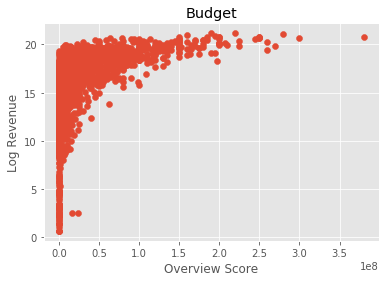

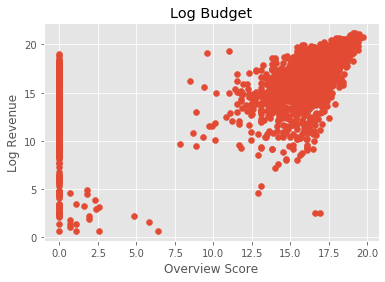

In [12]:
#Lets see how correlated the budget is to revenue
plt.scatter(train['budget'], target)
plt.title('Budget')
plt.xlabel("Overview Score")
plt.ylabel("Log Revenue")
plt.show()
            
plt.scatter(np.log1p(train['budget']),target)
plt.title('Log Budget')
plt.xlabel("Overview Score")
plt.ylabel("Log Revenue")
plt.show()

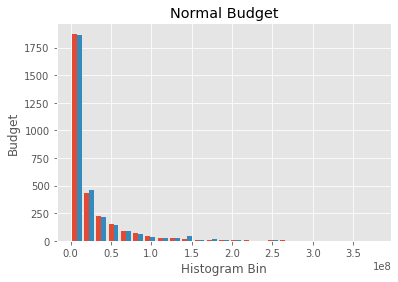

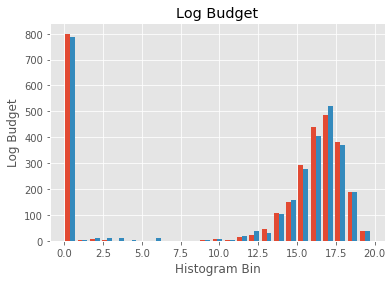

<Figure size 432x288 with 0 Axes>

In [13]:
#Check distributions to see if log or plain budget is more normally distributed
plt.hist(np.array(list(zip(train['budget'],test['budget']))), bins=25)
plt.title("Normal Budget")
plt.xlabel("Histogram Bin")
plt.ylabel("Budget")
plt.show()
plt.clf()
plt.hist(np.array(list((zip(np.log1p(train['budget']), np.log1p(test['budget']))))), bins=25)
plt.title("Log Budget")
plt.xlabel("Histogram Bin")
plt.ylabel("Log Budget")
plt.show()
plt.clf()
pro_train['logbudget'] = np.log1p(train['budget'].values)
pro_test['logbudget'] = np.log1p(test['budget'].values)                             

# Genres

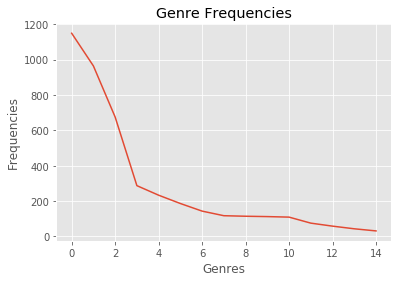

In [14]:
# Find how common each genre is
genres = []
for i in test["genres"]:
    if len(i) > 0:
        genres.append(i[0]["id"] )
    else:
        genres.append(-1)
plt.plot(pd.Series(genres).value_counts().values[:15])
plt.title("Genre Frequencies")
plt.xlabel("Genres")
plt.ylabel("Frequencies")
plt.show()

In [15]:
dict_to_onehot_df(test, train, pro_test, pro_train, 'name', "genres", 10)  

Index(['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure',
       'Crime', 'Science Fiction', 'Horror', 'Family'],
      dtype='object')


In [16]:
#Check up on data
pro_train.head()

,No name,James Bond Collection,Friday the 13th Collection,Pokémon Collection,Harry Potter Collection,Star Wars Collection,Halloween Collection,A Nightmare on Elm Street Collection,The Fast and the Furious Collection,The Pink Panther (Original) Collection,...,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Science Fiction,Horror,Family
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# Homepage

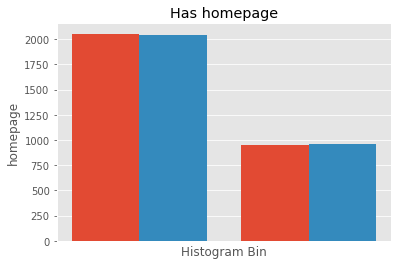

In [17]:
# Plot how many of the movies had a homepage
plt.hist(np.array(list((zip(train['homepage'].apply(lambda x: 1 if type(x) == str else 0).values,
                            test['homepage'].apply(lambda x: 1 if type(x) == str else 0).values)))), bins=2)
plt.title("Has homepage")
plt.xlabel("Histogram Bin")
plt.ylabel("homepage")
plt.xticks([])
plt.show() 

In [18]:
# Add how many of the movies had a homepage
pro_train['homepage'] = train['homepage'].apply(lambda x: 1 if type(x) == str else 0).values
pro_test['homepage'] = test['homepage'].apply(lambda x: 1 if type(x) == str else 0).values  

# Original_language

In [19]:
# Find the most popular languaages
test["original_language"].value_counts()[:10]

en    3776
fr     121
hi      76
ru      62
ja      53
es      52
it      32
de      31
ko      29
zh      27
Name: original_language, dtype: int64

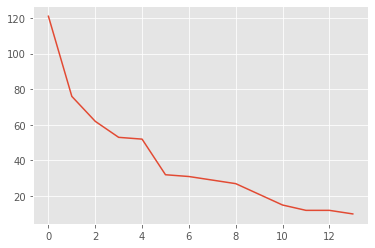

In [20]:
# Plot value frequency distribution of the data
langs = []
for i in test["original_language"]:
    if len(i) > 0:
        langs.append(i )
    else:
        langs.append(-1)
plt.plot(pd.Series(langs).value_counts().values[1:15])
plt.show()

In [21]:
# Add the most popular languages as one hot vectors
train["original_language2"] = train["original_language"].apply(lambda x: [{'name': x}])
test["original_language2"] = test["original_language"].apply(lambda x: [{'name': x}])
dict_to_onehot_df(test, train, pro_test, pro_train, 'name', "original_language2", 5)

Index(['en', 'fr', 'hi', 'ru', 'es'], dtype='object')


# Title

Number of words with >= 150 occurances:  9


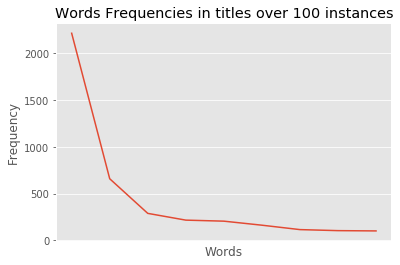

In [22]:
# Plot word frequencies in title
titles = ""
train_titles = ""
for i in train["title"]:
    titles += " " + i.lower()
    train_titles += " " + i.lower()
for i in test["title"]:
    titles += " " + str(i).lower()    
titles.replace(":","")
train_titles.replace(":","")
title_vals = pd.Series(titles.split(" ")).value_counts().values
for i in range(len(title_vals)):
    if title_vals[i] >= 100:
        over_100 = i + 1 
print("Number of words with >= 150 occurances: ", over_100)
plt.plot(title_vals[0:over_100])
plt.title("Words Frequencies in titles over 100 instances")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks([])
plt.show()

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import eli5
from sklearn.decomposition import SparsePCA

# Function to turn words into a ridge regression prediction of the overview and revenue
def process_words(train,test, pro_train, pro_test, col):
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=5)

    text = vectorizer.fit_transform(train[col].fillna('None'))

    #To help prevent overfitting form infrequent values
    transformer = SparsePCA(n_components=50,
        normalize_components=True,
        random_state=0)
    
    test_vecs = transformer.fit_transform(vectorizer.transform(test[col].fillna('None')).toarray())
    train_vecs = transformer.transform(vectorizer.transform(train[col].fillna('None')).toarray())
    
    ridge = Ridge()
    ridge.fit(train_vecs, target)
    lin_train = ridge.predict(train_vecs)
    lin_test =  ridge.predict(test_vecs)
    pro_train[col + '_ridge'] = lin_train - ridge.intercept_
    pro_test[col + '_ridge'] = lin_test - ridge.intercept_

    
process_words(train,test, pro_train, pro_test,'title')

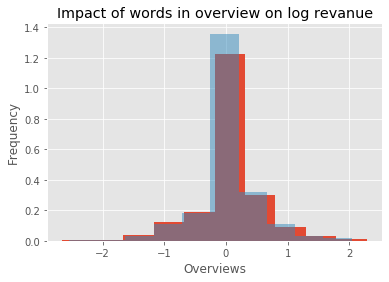

In [24]:
# Distribution of ridge scores
plt.hist(pro_test['title_ridge'].values, density=True)
plt.hist(pro_train['title_ridge'].values, density=True, alpha=0.5)
plt.title("Impact of words in overview on log revanue")
plt.xlabel("Overviews")
plt.ylabel("Frequency")
plt.show()

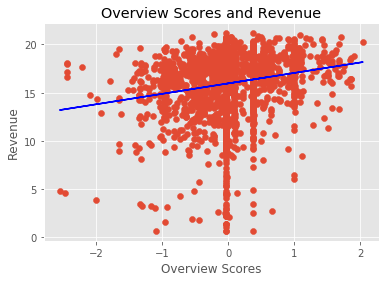

In [25]:
# Plot correlation of revenue and overview scores
plt.scatter(pro_train['title_ridge'], target)
plt.title("Overview Scores and Revenue")
plt.xlabel("Overview Scores")
plt.ylabel("Revenue")
plt.plot(pro_train['title_ridge'], Ridge().fit(pro_train['title_ridge'].to_numpy().reshape(-1,1), np.array(target).reshape(-1,1)).predict(pro_train['title_ridge'].values.reshape(-1,1)),'b')
plt.show()

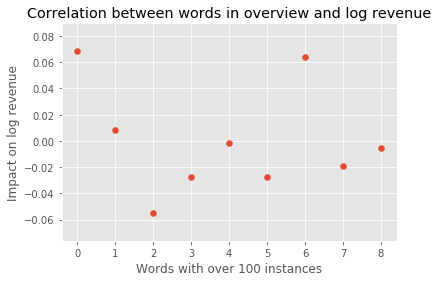

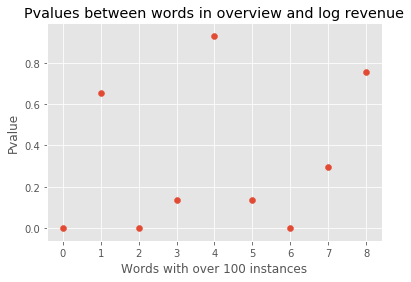

In [26]:
from scipy.stats import pointbiserialr

# Plot correlation values between words and revenue
corrs = {}
pvals = {}
for i in pd.Series(titles.split(" ")).value_counts()[:over_100].index:
    corrs[i] = pointbiserialr(train["title"].apply(lambda x: 1 if " " + i + " " in " " + str(x).lower() + " " else 0), target).correlation
    pvals[i] = pointbiserialr(train["title"].apply(lambda x: 1 if " " + i + " " in " " + str(x).lower() + " " else 0), target).pvalue
scorrs = list(np.sort(list(corrs.values())))[::-1]
spvals = list(np.sort(list(pvals.values())))

plt.scatter(range(len(scorrs)), corrs.values())
#plt.scatter(range(len(spvals)), pvals.values())
plt.title("Correlation between words in overview and log revenue")
plt.xlabel('Words with over 100 instances')
plt.ylabel('Impact on log revenue')
plt.show()
plt.clf()
plt.scatter(range(len(spvals)), pvals.values())
plt.title("Pvalues between words in overview and log revenue")
plt.xlabel('Words with over 100 instances')
plt.ylabel('Pvalue')
plt.show()

In [27]:
# Add the correletion values
title_corr = {}
for i in pd.Series(titles.split(" ")).value_counts().index[0:20]:
    title_corr[i] = pointbiserialr(train["title"].apply(lambda x: 1 if i in x.lower() else 0), target)
for i in title_corr.keys():
    if title_corr[i].pvalue < 0.4:
        pro_train["Title has " + i] = train["title"].apply(lambda x: title_corr[i].correlation if " " + i + " " in " " + str(x).lower() + " " else 0).values
        pro_test["Title has " + i] = test["title"].apply(lambda x: title_corr[i].correlation if " " + i + " " in " " + str(x).lower() + " " else 0).values


# Overview

In [28]:
train.overview[0:1].values

array(['When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.'],
      dtype=object)

Number of words with >= 100 occurances:  134


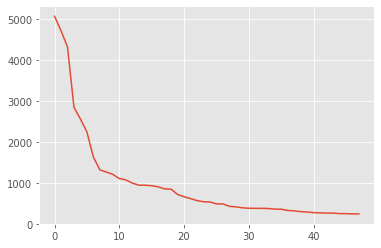

In [29]:
# Plot word frequencies in overview and find number of words in overview that show up over 100 times in train
overviews = ""
for i in train["overview"]:
    overviews += " " + str(i).lower() 

overviews.replace(":","")
overview_vals = pd.Series(overviews.split(" ")).value_counts().values
for i in range(len(overview_vals)):
    if overview_vals[i] >= 100:
        over_100 = i + 1 
    else:
        break
print("Number of words with >= 100 occurances: ", over_100)

plt.plot(overview_vals[2:50])
plt.show()

In [30]:
# Add reidge predictor of overview
process_words(train,test, pro_train, pro_test,'overview')

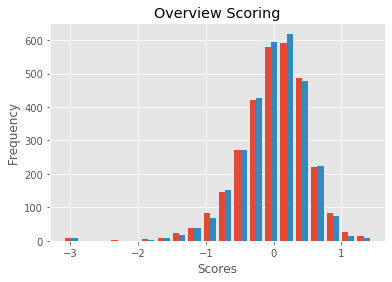

In [31]:
# plot the distribution of the scores
plt.hist(np.array(list(zip(pro_test.overview_ridge, pro_train.overview_ridge))), bins=20)
plt.title('Overview Scoring')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.show()

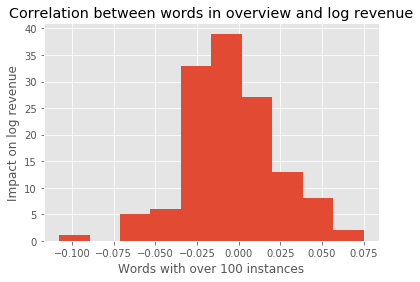

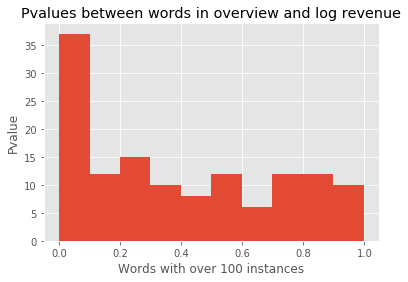

In [32]:
from scipy.stats import pointbiserialr

# Plot correlation values between overview words and revenue
corrs = {}
pvals = {}
for i in pd.Series(overviews.split(" ")).value_counts()[:over_100].index:
    corrs[i] = pointbiserialr(train["overview"].apply(lambda x: 1 if " " + i + " " in " " + str(x).lower() + " " else 0), target).correlation
    pvals[i] = pointbiserialr(train["overview"].apply(lambda x: 1 if " " + i + " " in " " + str(x).lower() + " " else 0), target).pvalue
scorrs = list(np.sort(list(corrs.values())))[::-1]
spvals = list(np.sort(list(pvals.values())))
#plt.scatter(range(len(scorrs)), corrs.values())
plt.hist(corrs.values())
plt.title("Correlation between words in overview and log revenue")
plt.xlabel('Words with over 100 instances')
plt.ylabel('Impact on log revenue')
plt.show()
plt.clf()
#plt.scatter(range(len(spvals)), pvals.values())
plt.hist(pvals.values())
plt.title("Pvalues between words in overview and log revenue")
plt.xlabel('Words with over 100 instances')
plt.ylabel('Pvalue')
plt.show()

In [33]:
# Add the values to the data
over_corr = {}
for i in pd.Series(titles.split(" ")).value_counts().index[0:20]:
    over_corr[i] = pointbiserialr(train["overview"].apply(lambda x: 1 if i in str(x).lower() else 0), target)
for i in title_corr.keys():
    if title_corr[i].pvalue < 0.4:
        pro_train["Overview has " + i] = train["overview"].apply(lambda x: over_corr[i].correlation if " " + i + " " in " " + str(x).lower() + " " else 0).values
        pro_test["Overview has " + i] = test["overview"].apply(lambda x: over_corr[i].correlation if " " + i + " " in " " + str(x).lower() + " " else 0).values


# Popularity

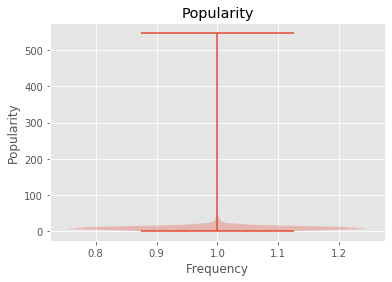

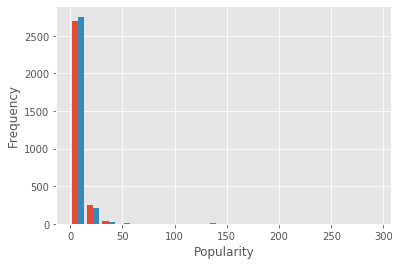

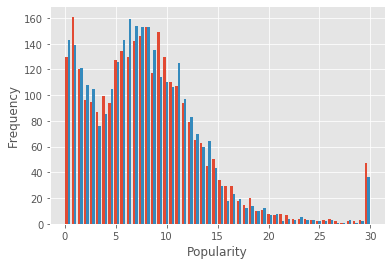

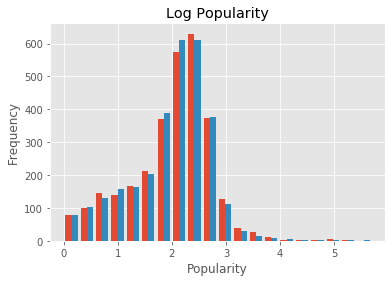

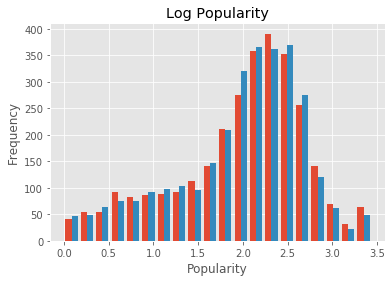

In [34]:
# Plot frequencies of popularit
plt.violinplot(test.popularity)
plt.title('Popularity')
plt.xlabel("Frequency")
plt.ylabel("Popularity")
plt.show()
plt.hist(np.array(list(zip(test.popularity,train.popularity))), bins=20)
plt.ylabel("Frequency")
plt.xlabel("Popularity")
plt.show()
plt.hist(np.array(list(zip(test.popularity.apply(lambda x: min(x,30)),train.popularity.apply(lambda x: min(x,30))))), bins=50)
plt.ylabel("Frequency")
plt.xlabel("Popularity")
plt.show()
plt.hist(np.log1p(np.array(list(zip(test.popularity,train.popularity)))), bins=20)
plt.ylabel("Frequency")
plt.xlabel("Popularity")
plt.title('Log Popularity')
plt.show()
plt.hist(np.log1p(np.array(list(zip(test.popularity.apply(lambda x: min(x,30)),train.popularity.apply(lambda x: min(x,30)))))), bins=20)
plt.ylabel("Frequency")
plt.xlabel("Popularity")
plt.title('Log Popularity')
plt.show()

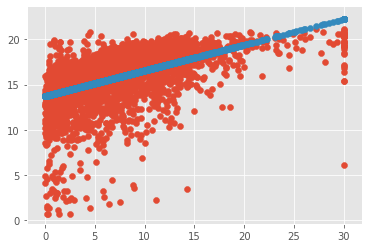

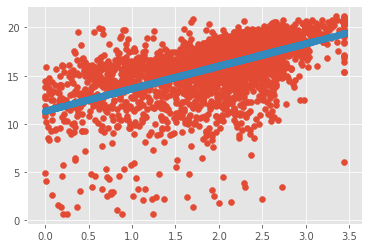

In [35]:
max_30_pop = train.popularity.apply(lambda x: min(x,30)).values
plt.scatter(max_30_pop,target)
plt.scatter(max_30_pop, Ridge().fit(max_30_pop.reshape(-1, 1),target.reshape(-1, 1)).predict(max_30_pop.reshape(-1, 1)).reshape(-1, ))

plt.show()
plt.scatter(np.log1p(max_30_pop),target)
plt.scatter(np.log1p(max_30_pop), Ridge().fit(np.log1p(max_30_pop).reshape(-1, 1),target.reshape(-1, 1)).predict(np.log1p(max_30_pop).reshape(-1, 1)).reshape(-1, ))
plt.show()

In [36]:
from sklearn.preprocessing import StandardScaler

# Scale log popularity
scaler = StandardScaler()
scaler.fit(np.log1p(test['popularity'].values).reshape(-1,1))
sc_pop_test = scaler.transform(np.log1p(np.array(test['popularity'].apply(lambda x: min(x,30)).values)).reshape(-1,1)).reshape((-1,))
sc_pop_train = scaler.transform(np.log1p(np.array(train['popularity'].apply(lambda x: min(x,30)).values)).reshape(-1,1)).reshape((-1,))


In [37]:
pro_train['sc_log_pop'] = sc_pop_train
pro_test['sc_log_pop'] = sc_pop_test
pro_train['popularity'] = train['popularity']
pro_test['popularity'] = test['popularity']

# Poster_path

In [38]:
# Check to see if poster path has any meaningful data
for i in test.poster_path.value_counts().values:
    if i > 1:
        print("Bigger than 1")

# Production_Companies

In [39]:
train['production_companies'].values[0]

[{'name': 'Paramount Pictures', 'id': 4},
 {'name': 'United Artists', 'id': 60},
 {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]

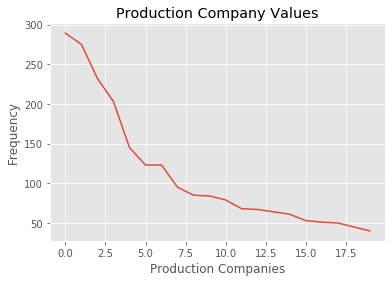

In [40]:
# Plot frequencies of values of production companies
arr_comps = test['production_companies'].apply(lambda x: [x[i]['name'] for i in range(len(x))]).values
all_comps = []
for comps in arr_comps:
    for comp in comps:
        all_comps.append(comp)

plt.plot(pd.Series(list(sorted(all_comps))).value_counts().values[:20])
plt.title('Production Company Values')
plt.xlabel('Production Companies')
plt.ylabel('Frequency')
plt.show()

In [41]:
# Add dictionaries to data
dict_to_onehot_df(test, train, pro_test, pro_train, 'name', "production_companies", 15)   

Index(['Warner Bros.', 'Universal Pictures', 'No name', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema', 'Touchstone Pictures',
       'Walt Disney Pictures', 'Columbia Pictures Corporation', 'Canal+',
       'TriStar Pictures', 'Relativity Media', 'United Artists'],
      dtype='object')


# production_countries

In [42]:
train['production_countries'].values[0]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

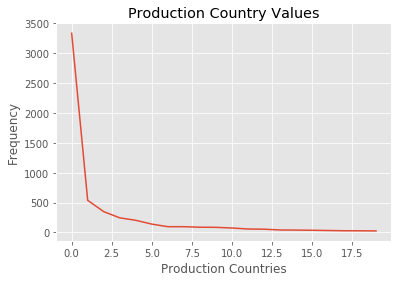

In [43]:
# Plot frequencies of values of production countries
arr_comps = test['production_countries'].apply(lambda x: [x[i]['name'] for i in range(len(x))]).values
all_comps = []
for comps in arr_comps:
    for comp in comps:
        all_comps.append(comp)

plt.plot(pd.Series(list(sorted(all_comps))).value_counts().values[:20])
plt.title('Production Country Values')
plt.xlabel('Production Countries')
plt.ylabel('Frequency')
plt.show()

In [44]:
# Find countries that show up in the training data more than 50 times
countries = []
for i in train['production_companies']:
    for s in i:
        countries.append(s['name'])
over_50 = 0
for i in pd.Series(countries).value_counts().values:
    if i >= 50:
        over_50 += 1
print(over_50)

11


In [45]:
dict_to_onehot_df(test, train, pro_test, pro_train, 'name', "production_countries", over_50)   

Index(['United States of America', 'United Kingdom', 'France', 'Germany',
       'Canada', 'India', 'Italy', 'No name', 'Japan', 'Australia', 'Spain'],
      dtype='object')


# release_date

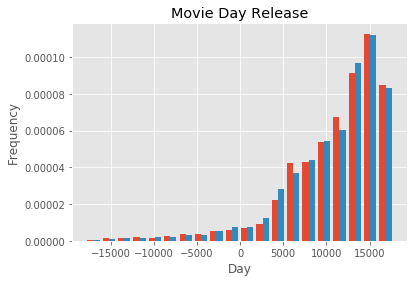

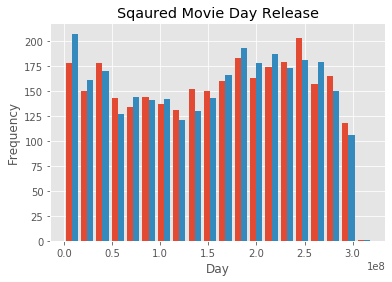

In [46]:
import datetime
import time

def process_date(df,col):
    ref_date = datetime.date(1970,1,1)
    df_date_values = df[col].values
    date_deltas = []
    for i in df[col]:
        if type(i) == float:
            date_deltas.append(0)
        else:
            temp_date_val = [int(s) for s in i.split('/')]
            temp_date_val =  [temp_date_val[2], temp_date_val[0], temp_date_val[1]]
            if temp_date_val[0] <= 9:
                temp_date_val[0] = int('200' + str(temp_date_val[0]))
            elif temp_date_val[0] < 19:
                temp_date_val[0] = int('20' + str(temp_date_val[0]))
            else:
                temp_date_val[0] = int('19' + str(temp_date_val[0]))
            temp_date = datetime.date(temp_date_val[0], temp_date_val[1], temp_date_val[2])
            date_deltas.append((temp_date-ref_date).days)
    return np.array(date_deltas)

train_days = process_date(train,'release_date')
test_days = process_date(test,'release_date')
days_min = min((min(train_days),min(test_days)))
plt.hist(np.array(list(zip(train_days,
                           test_days))), bins=20, density=True)
plt.title("Movie Day Release")
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.show()
train_days + days_min
plt.hist(np.array(list(zip(train_days ,
                           test_days ))) ** 2, bins=20)
plt.title("Sqaured Movie Day Release")
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.show()

In [47]:
# Add the days to trainining data 
sqtrain_dates = process_date(train,'release_date') ** 2
sqtest_dates = process_date(test,'release_date') ** 2 

scaler.fit(sqtest_dates.reshape((-1,1)))

pro_train['sqscaled_dates'] = scaler.transform(sqtrain_dates.reshape((-1,1))).reshape((-1,))
pro_test['sqscaled_dates'] = scaler.transform(sqtest_dates.reshape((-1,1))).reshape((-1,))

scaler.fit(test_days.reshape((-1,1)))

pro_train['scaled_dates'] = scaler.transform(train_days.reshape((-1,1))).reshape((-1,))
pro_test['scaled_dates'] = scaler.transform(test_days.reshape((-1,1))).reshape((-1,))

In [48]:
# Add the date specific details
test_release_dates = pd.to_datetime(test['release_date'])
train_release_dates = pd.to_datetime(train['release_date'])

pro_test['weekday'] = test_release_dates.dt.dayofweek
pro_train['weekday'] = train_release_dates.dt.dayofweek
pro_test['month'] = test_release_dates.dt.month
pro_train['month'] = train_release_dates.dt.month
pro_test['year'] = test_release_dates.dt.year
pro_train['year'] = train_release_dates.dt.year

# runtime

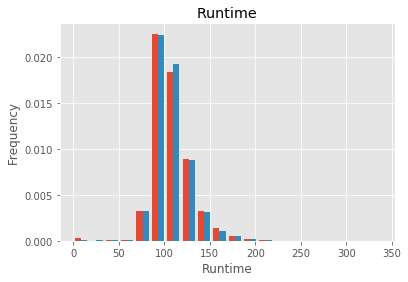

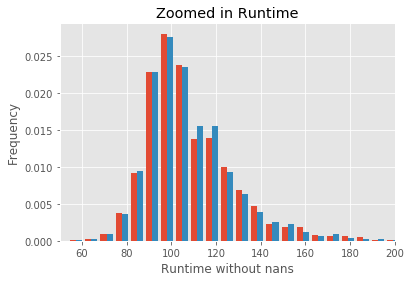

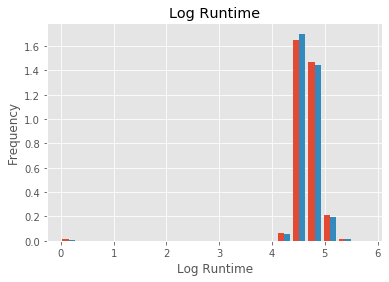

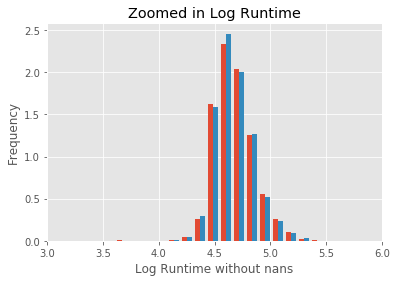

In [49]:
# Investigate runtime distribution
plt.hist(np.array(list(zip(train['runtime'],test['runtime']))), bins=20, density=True)
plt.title("Runtime")
plt.ylabel('Frequency')
plt.xlabel("Runtime")
plt.show()
plt.hist((np.array(list(zip(train['runtime'],test['runtime'])))), bins=50, density=True)
plt.title("Zoomed in Runtime")
plt.ylabel('Frequency')
plt.xlabel("Runtime without nans")
plt.xlim((50,200))
plt.show()
plt.hist(np.log1p(np.array(list(zip(train['runtime'],test['runtime'])))), bins=20, density=True)
plt.title("Log Runtime")
plt.ylabel('Frequency')
plt.xlabel("Log Runtime")
plt.show()
plt.hist(np.log1p(np.array(list(zip(train['runtime'],test['runtime'])))), bins=50, density=True)
plt.title("Zoomed in Log Runtime")
plt.ylabel('Frequency')
plt.xlabel("Log Runtime without nans")
plt.xlim((3,6))
plt.show()

In [50]:
pro_train['runtime'] = train['runtime'].values
pro_test['runtime'] = test['runtime'].values
pro_train['logruntime'] = np.log1p(train['runtime'].values)
pro_test['logruntime'] = np.log1p(test['runtime'].values)

# spoken_languages

English     3831
Français     423
Español      320
Deutsch      250
Pусский      212
dtype: int64


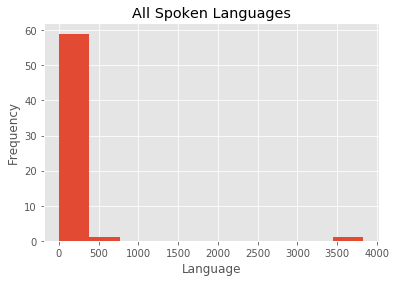

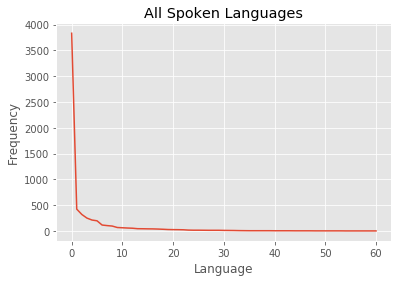

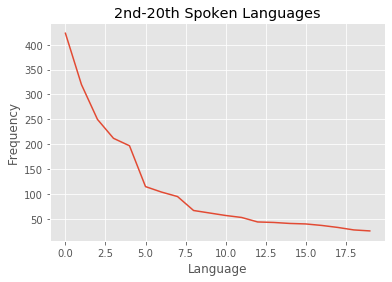

In [51]:
# Invitigate languages and frequencies
arr_langs = test['spoken_languages'].apply(lambda x: [x[i]['name'] for i in range(len(x))]).values
all_langs = []
for langs in arr_langs:
    for lang in langs:
        all_langs.append(lang)
print(pd.Series(list(sorted(all_langs))).value_counts()[:5])
plt.hist(pd.Series(list(sorted(all_langs))).value_counts().values)    
plt.title("All Spoken Languages")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.show()
plt.plot(pd.Series(list(sorted(all_langs))).value_counts().values)
plt.title("All Spoken Languages")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.show()
plt.plot(pd.Series(list(sorted(all_langs))).value_counts().values[1:21])
plt.title("2nd-20th Spoken Languages")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.show()

In [52]:
spolangs = []
for i in train['spoken_languages']:
    for s in i:
        spolangs.append(s['name'])
over_20 = 0
for i in pd.Series(spolangs).value_counts().values:
    if i >=20:
        over_20 += 1
print(over_20)

21


In [53]:
dict_to_onehot_df(test, train, pro_test, pro_train, 'name', "spoken_languages", over_20)   

Index(['English', 'Français', 'Español', 'Deutsch', 'Pусский', 'Italiano',
       '日本語', '普通话', 'हिन्दी', '', 'العربية', 'Português', '广州话 / 廣州話',
       '한국어/조선말', 'Polski', 'Latin', 'Magyar', 'No name', 'Český', 'ภาษาไทย',
       'தமிழ்'],
      dtype='object')


# Status

In [54]:
test['status'].value_counts(), train['status'].value_counts()

(Released           4389
 Post Production       5
 Rumored               2
 Name: status, dtype: int64, Released    2996
 Rumored        4
 Name: status, dtype: int64)

In [55]:
# Add status values
status_dict = {'Released':0, 'Post Production': 0, 'Rumored':0, np.nan:-1}
pro_train['status'] = [status_dict[i] for i in train['status'].values]
pro_test['status'] = [status_dict[i] for i in test['status'].values]

# Tagline

In [56]:
# Process the tag lines
process_words(train,test, pro_train, pro_test,'tagline')

# Keywords

In [57]:
test['Keywords'].values[0]

[{'id': 11451, 'name': 'pok√©mon'}, {'id': 11551, 'name': 'pocket monsters'}]

woman director          282
independent film        229
duringcreditsstinger    216
based on novel          201
murder                  182
dtype: int64


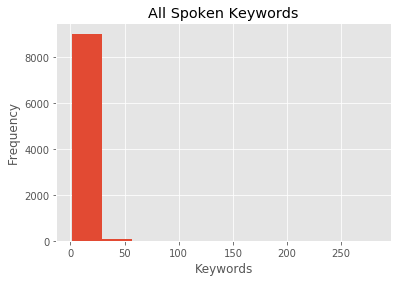

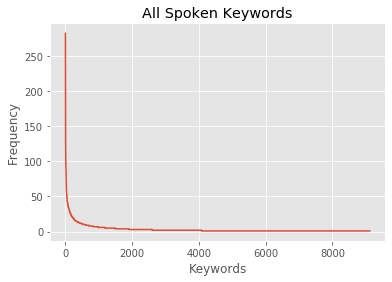

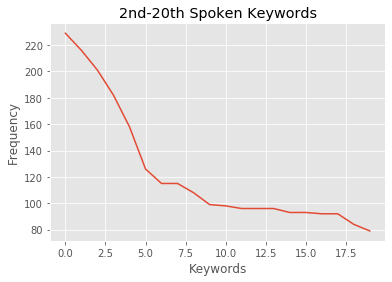

In [58]:
# Investigate Key word frequencies
arr_keys = test['Keywords'].apply(lambda x: [x[i]['name'] for i in range(len(x))]).values
all_keys= []
for keys in arr_keys:
    for key in keys:
        all_keys.append(key)
print(pd.Series(list(sorted(all_keys))).value_counts()[:5])
plt.hist(pd.Series(list(sorted(all_keys))).value_counts().values)    
plt.title("All Spoken Keywords")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.show()
plt.plot(pd.Series(list(sorted(all_keys))).value_counts().values)
plt.title("All Spoken Keywords")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.show()
plt.plot(pd.Series(list(sorted(all_keys))).value_counts().values[1:21])
plt.title("2nd-20th Spoken Keywords")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.show()

In [59]:
Keywords = []
for i in train['Keywords']:
    for s in i:
        Keywords.append(s['name'])
over_75 = 0
for i in pd.Series(Keywords).value_counts().values:
    if i >= 75:
        over_75 += 1
print(over_75)

9


In [60]:
dict_to_onehot_df(test, train, pro_test, pro_train, 'name', "Keywords", over_75)   

Index(['No name', 'woman director', 'independent film', 'duringcreditsstinger',
       'based on novel', 'murder', 'violence', 'love', 'revenge'],
      dtype='object')


In [61]:
# Turns a list of dictionaries into a list with a key for the dictionaries
def lsdict_to_lsstr(lsdict, key='name'):

    temp_ls = []
    for movie in lsdict:
        temp = ''
        for value in movie:
            temp += ' ' + value[key].replace(' ','_')
        temp_ls.append(temp)
    return temp_ls

In [62]:
# takes a list of dictionaries and turns it into a list of dictionary values of key 'key'
def process_worddicts(train, test, pro_train, pro_test, col, tag='name'):
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=5)

    linked = []
    for i in train[col]:
        if type(i) == float:
            link.append('no_' + col)
        else:
            temp = ''
            for s in i:
                temp += s[tag].replace(' ','_') + " "
            linked.append(temp) 
    text = vectorizer.fit_transform(linked)
    ridge = Ridge()
    ridge.fit(text, target)


    #To help prevent overfitting form infrequent values
    transformer = SparsePCA(n_components=50,
        normalize_components=True,
        random_state=0)

    test_vecs = transformer.fit_transform(vectorizer.transform(lsdict_to_lsstr(test[col].values)).toarray())
    train_vecs = transformer.transform(vectorizer.transform(lsdict_to_lsstr(train[col].values)).toarray())
    
    ridge = Ridge()
    ridge.fit(train_vecs, target)
    lin_train = ridge.predict(train_vecs)
    lin_test =  ridge.predict(test_vecs)
    pro_train[col + '_ridge'] = lin_train - ridge.intercept_
    pro_test[col + '_ridge'] = lin_test - ridge.intercept_

    

    return eli5.show_weights(ridge, vec=vectorizer, top=20)
process_worddicts(train, test, pro_train, pro_test, 'Keywords', tag='name')

Weight?,Feature
+16.019,ancient_rome
+4.715,african_american
+3.900,aids
+3.735,1930s
+3.013,airport
+3.003,actress
+2.766,1920s
+2.720,adoption
+2.465,_navy
+2.372,1940s


# Cast

In [63]:
test['cast'].values[0][:2]

[{'cast_id': 3,
  'character': 'Tonio',
  'credit_id': '52fe44e7c3a368484e03d68d',
  'gender': 0,
  'id': 82140,
  'name': 'Craig Blair',
  'order': 0,
  'profile_path': None},
 {'cast_id': 4,
  'character': 'Alice',
  'credit_id': '52fe44e7c3a368484e03d691',
  'gender': 1,
  'id': 111768,
  'name': 'Emily Bauer',
  'order': 1,
  'profile_path': None}]

In [64]:
# Check out gender values
gend_vals = [[i['gender'] for i in x] for x in test['cast']]
gend_flat = []
for i in gend_vals:
    for s in i:
        gend_flat.append(s)
pd.Series.value_counts(gend_flat)

2    41074
0    31691
1    20458
dtype: int64

In [65]:
# Add gender counts
train_males = []
train_females = []
train_none = []
for cast in train['cast']:
    temp_male = 0
    temp_female = 0
    temp_none = 0
    for member in cast:
        if member['gender'] == 0:
            temp_male += 1
        if member['gender'] == 1:
            temp_female += 1
        if member['gender'] == 2:
            temp_none += 1
    train_males.append(temp_male)
    train_females.append(temp_female)
    train_none.append(temp_none)
pro_train['males'] = train_males
pro_train['females'] = train_females 
pro_train['no_gender'] = train_none
pro_train['gender_ratio'] = [-1 if train_females[i] == 0 else train_males[i]/train_females[i] for i in range(len(train_males))]    

test_males = []
test_females = []
test_none = []
for cast in test['cast']:
    temp_male = 0
    temp_female = 0
    temp_none = 0
    for member in cast:
        if member['gender'] == 0:
            temp_male += 1
        if member['gender'] == 1:
            temp_female += 1
        if member['gender'] == 2:
            temp_none += 1
    test_males.append(temp_male)
    test_females.append(temp_female)
    test_none.append(temp_none)
pro_test['males'] = test_males
pro_test['females'] = test_females 
pro_test['no_gender'] = test_none            
pro_test['gender_ratio'] = [-1 if test_females[i] == 0 else test_males[i]/test_females[i] for i in range(len(test_males))]    

 

In [66]:
process_worddicts(train, test, pro_train, pro_test, 'cast', tag='name')

Weight?,Feature
+15.975,_murray_abraham
+2.897,_lewis
+2.548,_bailey
+2.432,_daily
+2.230,_benjamin
+1.815,_g
+1.625,_john
+1.619,_king
+1.433,_cobb
+1.405,_marshall


In [67]:
all_cast = []
for movie in train['cast']:
    for cast in movie:
        all_cast.append(cast['name'])
cast_counts = pd.Series(all_cast).value_counts()
pop_cast = []
for i in range(len(cast_counts.values)):
    if cast_counts.values[i] > 10:
        pop_cast.append(cast_counts.index[i])
len(pop_cast)


294

# Crew

In [68]:
test['crew'].values[0][:2]

[{'credit_id': '52fe44e7c3a368484e03d683',
  'department': 'Directing',
  'gender': 0,
  'id': 65429,
  'job': 'Director',
  'name': 'Kunihiko Yuyama',
  'profile_path': '/9z3LqqCMRZWyptfIZnlAdG7CnaZ.jpg'},
 {'credit_id': '52fe44e7c3a368484e03d689',
  'department': 'Writing',
  'gender': 2,
  'id': 25761,
  'job': 'Writer',
  'name': 'Hideki Sonoda',
  'profile_path': None}]

In [69]:
# Get gender counts
gend_vals = [[i['gender'] for i in x] for x in test['crew']]
gend_flat = []
for i in gend_vals:
    for s in i:
        gend_flat.append(s)
pd.Series.value_counts(gend_flat)

0    61652
2    35833
1     9008
dtype: int64

In [70]:
# Add the number of people of each gender and their ratio
train_males = []
train_females = []
train_none = []
for cast in train['crew']:
    temp_male = 0
    temp_female = 0
    temp_none = 0
    for member in cast:
        if member['gender'] == 0:
            temp_male += 1
        if member['gender'] == 1:
            temp_female += 1
        if member['gender'] == 2:
            temp_none += 1
    train_males.append(temp_male)
    train_females.append(temp_female)
    train_none.append(temp_none)
pro_train['crew_males'] = train_males
pro_train['crew_females'] = train_females 
pro_train['crew_no_gender'] = train_none
pro_train['crew_gender_ratio'] = [-1 if train_females[i] == 0 else train_males[i]/train_females[i] for i in range(len(train_males))]    
pro_train['crew_count'] = train['crew'].apply(lambda x: len(x))

test_males = []
test_females = []
test_none = []
for cast in test['crew']:
    temp_male = 0
    temp_female = 0
    temp_none = 0
    for member in cast:
        if member['gender'] == 0:
            temp_male += 1
        if member['gender'] == 1:
            temp_female += 1
        if member['gender'] == 2:
            temp_none += 1
    test_males.append(temp_male)
    test_females.append(temp_female)
    test_none.append(temp_none)
pro_test['crew_males'] = test_males
pro_test['crew_females'] = test_females 
pro_test['crew_no_gender'] = test_none            
pro_test['crew_gender_ratio'] = [-1 if test_females[i] == 0 else test_males[i]/test_females[i] for i in range(len(test_males))]    
pro_test['crew_count'] = test['crew'].apply(lambda x: len(x))
 

In [71]:
process_worddicts(train, test, pro_train, pro_test, 'crew', tag='name')

Weight?,Feature
+15.978,_capp
+3.720,_burton
+3.468,_beasley
+2.697,_bourgeois
+2.591,_brooks
+2.357,_ateah
+2.101,_bailey
+2.081,_austerberry
+1.976,_campanelli
+1.738,_bourne


In [72]:
# Takes in a list of dictionaries and returns the count of the top twenty values under the key 'tag'
def dict_count(train, test, pro_train, pro_test, col, tag, top=20):
    cats = {'-1'}
    for i in list(train[col]) + list(test[col]):
        if not type(i) == float:
            for s in i:
                cats.add(s[tag])
    cats = list(cats)[:min(len(list(cats)), top)]
    counts = []
    for movie in train[col].values:
        if type(movie) == float:
            counts.append([1] + [0 for i in range(len(cats) - 1)])
        else:
            temp_sum = np.zeros((len(cats),))
            for element in movie:
                temp = []
                for cat in cats:
                    if element[tag] == cat:
                        temp.append(1)
                    else:
                        temp.append(0)
                        
                temp_sum += np.array(temp)
            counts.append(temp_sum)
            
    for cat in range(len(cats)):
        pro_train['Has ' + str(cats[cat])] = np.array(counts)[:, cat]
        
    counts = []    
    for movie in test[col].values:
        if type(movie) == float:
            counts.append([0 for i in cats])
        else:
            for element in movie:
                temp = []
                temp_sum = np.zeros((len(cats),))
                for cat in cats:
                    if element[tag] == cat:
                        temp.append(1)
                    else:
                        temp.append(0)
                        
                temp_sum += np.array(temp)
                
            counts.append(temp_sum)
            
    for cat in range(len(cats)):
        pro_test['Has ' + str(cats[cat])] = np.array(counts)[:, cat]
        
    print(cats)        
dict_count(train, test, pro_train, pro_test, 'crew', 'department')  
dict_count(train, test, pro_train, pro_test, 'crew', 'job', 20)  
process_worddicts(train, test, pro_train, pro_test, 'crew', tag='job')

['Production', 'Lighting', 'Visual Effects', '-1', 'Sound', 'Actors', 'Editing', 'Costume & Make-Up', 'Art', 'Camera', 'Writing', 'Directing', 'Crew']
['Publicist', 'Motion Capture Artist', 'Supervising Technical Director', 'Supervising Animator', 'Visual Effects Supervisor', 'Loader', 'Propmaker', 'Digital Effects Producer', 'Hairstylist', 'Pyrotechnic Supervisor', 'Animation Supervisor', 'treatment', 'Characters', 'Script', 'Script Editor', 'Music Editor', 'Tailor', 'Foley Editor', '3D Generalist', 'Casting Consultant']


Weight?,Feature
+15.961,animation animation_manager
+0.747,24_frame_playback


In [73]:
process_worddicts(train, test, pro_train, pro_test, 'crew', tag='department')

Weight?,Feature
+15.962,directing visual_effects


# More Features

[17:17:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


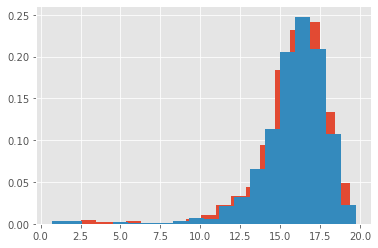

In [74]:
# Use xgboost to fill in nans in budget
no_nan_budget = pro_test.loc[pro_test.logbudget != 0].append(pro_train.loc[pro_train.logbudget != 0])
xbgr = xgb.XGBRegressor()
xbgr.fit(no_nan_budget.drop('logbudget', axis=1).values, no_nan_budget['logbudget'].values)
test_fills = []
for row in range(pro_test.shape[0]):
    if pro_test.loc[row, 'logbudget'] == 0:
        test_fills.append(xbgr.predict([pro_test.loc[row, :].drop('logbudget').values])[0])
    else:
        test_fills.append(pro_test.loc[row, 'logbudget'])
pro_test['logbudget2'] = np.array(test_fills)

train_fills = []
for row in range(pro_train.shape[0]):
    if pro_train.loc[row, 'logbudget'] == 0:
        train_fills.append(xbgr.predict([pro_train.loc[row, :].drop('logbudget').values])[0])
    else:
        train_fills.append(pro_train.loc[row, 'logbudget'])
pro_train['logbudget2'] = np.array(train_fills)
plt.hist(pro_test.logbudget2.values, bins = 20, density=True)
plt.hist(pro_train.logbudget2.values, bins = 20, density=True)
plt.show()

In [75]:
# Add budget ratios
pro_test['pop/budg'] = test['popularity']/test['budget']
pro_test['pop/logbudg'] = test['popularity']/pro_test['logbudget']
pro_test['logpop/logbudg'] = pro_test['sc_log_pop']/pro_test['logbudget']
pro_test['logpop/budg'] = pro_test['sc_log_pop']/test['budget']
pro_test['year/logbudg'] = pro_test['year']/pro_test['logbudget']
pro_test['logbudg/scyear'] = pro_test['logbudget']/(scaler.fit_transform(pro_test['year'].values.reshape(-1, 1)).reshape(-1, ))
pro_test['logbudg/year'] = pro_test['logbudget']/pro_test['year']


pro_train['pop/budg'] = train['popularity']/train['budget']
pro_train['pop/logbudg'] = train['popularity']/pro_train['logbudget']
pro_train['logpop/logbudg'] = pro_train['sc_log_pop']/pro_train['logbudget']
pro_train['logpop/budg'] = pro_train['sc_log_pop']/train['budget']
pro_train['year/logbudg'] = pro_train['year']/pro_train['logbudget']
pro_train['logbudg/scyear'] = pro_train['logbudget']/(scaler.transform(pro_train['year'].values.reshape(-1, 1)).reshape(-1, ))
pro_train['logbudg/year'] = pro_train['logbudget']/pro_train['year']

def div_feats(feats, test=pro_test, train=pro_train):
    for feat in feats:
        for feat2 in feats:
            if feat != feat2:
                test[feat+'/'+feat2] = test[feat].values/test[feat2].values
                train[feat+'/'+feat2] = train[feat].values/train[feat2].values
def mult_feats(feats, test=pro_test, train=pro_train):
    for feat in feats:
        for feat2 in feats:
            if feat != feat2:
                test[feat+'/'+feat2] = test[feat].values*test[feat2].values
                train[feat+'/'+feat2] = train[feat].values*train[feat2].values

feats =['logbudget','sc_log_pop','popularity','crew_count','logruntime','runtime']                
div_feats(feats)
mult_feats(feats)

/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

divide by zero encountered in true_divide

/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in true_divide

/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning:

divide by zero encountered in true_divide

/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning:

invalid value encountered in true_divide



# Feature Selection

In [76]:
import math

# Function to find mean of a col without nans or inf affecting the mean 
def mean(series):
    vals = []
    for i in series:
        if abs(i) != float('inf') and not math.isnan(i):
            vals.append(i)
    return sum(vals)/len(vals)


In [79]:
# Scale the data
pro_col = pro_test.columns
for col in range(len(pro_test.columns)):
    if len(pro_test[pro_col[col]].value_counts().values) < 2 or len(pro_train[pro_col[col]].value_counts().values) < 2:
        pro_test.drop([pro_col[col]], inplace=True, axis=1)
        pro_train.drop([pro_col[col]], inplace=True, axis=1)
        col -= 1

for col in pro_test.columns:
    m = mean(pro_test[col])
    pro_test[col] = pro_test[col].apply(lambda x: m if math.isnan(x) or abs(x) == float('inf') else x)

for col in pro_train.columns:
    m = mean(pro_test[col])
    print(m)
    pro_train[col] = pro_train[col].apply(lambda x: m if math.isnan(x) or abs(x) == float('inf') else x)

pro_test2 = pro_test.copy()
pro_train2 = pro_train.copy()
pro_test2[pro_test.columns] = scaler.fit_transform(pro_test.values)
pro_train2[pro_train.columns] = scaler.transform(pro_train.values)

pro_train2.head()

0.08935879945429741
0.002273760800363802
0.001136880400181901
0.0009095043201455207
0.001364256480218281
0.001364256480218281
0.001136880400181901
0.0009095043201455207
0.00045475216007276033
0.001136880400181901
0.00045475216007276033
0.0006821282401091405
0.00045475216007276033
0.0009095043201455207
0.00045475216007276033
0.0009095043201455207
0.0006821282401091405
0.19899785254115857
11.799166547623496
0.17394270122783084
0.11937244201909959
0.1662119145065939
0.020691223283310595
0.1466575716234652
0.023192360163710776
0.043883583447021375
0.05411550704865848
0.029331514324693043
0.05252387448840382
0.32287403365165984
0.8585720782173716
0.027512505684402
0.017280582082764895
0.01409731696225557
0.01182355616189177
2.7667222259872023e-16
0.018297771090891764
0.0004195596894608597
-0.00024204328488677118
-0.00027876204173360626
0.00037825944042036027
0.0005419946728055875
0.00021383668931142762
-0.00041081093562454074
-0.0001279796802035341
-0.00010752351883114959
3.699733662779967e

,No name,James Bond Collection,Friday the 13th Collection,Pokémon Collection,Harry Potter Collection,Star Wars Collection,Halloween Collection,The Fast and the Furious Collection,The Pink Panther (Original) Collection,Saw Collection,...,logruntime/logbudget,logruntime/sc_log_pop,logruntime/popularity,logruntime/crew_count,logruntime/runtime,runtime/logbudget,runtime/sc_log_pop,runtime/popularity,runtime/crew_count,runtime/logruntime
0,-0.313253,-0.047738,-0.033737,-0.030172,-0.036961,-0.036961,-0.033737,-0.030172,-0.02133,-0.033737,...,0.551434,0.049871,-6.119887e-14,2.900044e-14,-0.695736,0.260634,0.024151,2.290664e-14,1.540312e-14,-0.695736
1,-0.313253,-0.047738,-0.033737,-0.030172,-0.036961,-0.036961,-0.033737,-0.030172,-0.02133,-0.033737,...,0.783174,0.330570,-3.737215e-01,2.880102e+00,0.236988,0.768507,0.314774,-3.222808e-01,2.976703e+00,0.236988
2,-0.313253,-0.047738,-0.033737,-0.030172,-0.036961,-0.036961,-0.033737,-0.030172,-0.02133,-0.033737,...,0.415958,1.986854,-2.703255e-02,-9.579402e-01,-0.139941,0.312491,1.872019,-6.654655e-02,-9.518820e-01,-0.139941
3,-0.313253,-0.047738,-0.033737,-0.030172,-0.036961,-0.036961,-0.033737,-0.030172,-0.02133,-0.033737,...,0.340987,-0.791538,1.279566e+01,2.456216e+00,0.666625,0.461937,-0.866549,1.442916e+01,2.797511e+00,0.666625
4,3.192309,-0.047738,-0.033737,-0.030172,-0.036961,-0.036961,-0.033737,-0.030172,-0.02133,-0.033737,...,-1.575221,-1.721595,-1.129437e+00,-1.312610e+00,0.474971,-1.475236,-1.815077,-1.087476e+00,-1.274757e+00,0.474971


In [80]:
from sklearn.metrics import mean_squared_log_error

# Function to get a CV
def check_CV(train,target,model):
    splits = 10
    kf = KFold(n_splits=splits)
    scores = 0
    for train_index, test_index in kf.split(train):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = target[train_index], target[test_index]
        model.fit(X_train, y_train)
        scores += np.sqrt(mean_squared_log_error(np.exp(y_test)-1, np.exp(model.predict(X_test))-1))

    return scores/splits
check_CV(pro_train2.values, target, xgb.XGBRegressor())

[17:19:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

1.9322372594965223

In [81]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel

#Get weights
xgbr = xgb.XGBRegressor()
perm = PermutationImportance(xgbr, cv=5)
perm.fit(pro_train2.values, target)
eli5.show_weights(perm)

[17:19:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Weight,Feature
0.1189 ± 0.1230,x153
0.0600 ± 0.0674,x158
0.0600 ± 0.0513,x164
0.0401 ± 0.0337,x83
0.0191 ± 0.0143,x18
0.0107 ± 0.0098,x117
0.0069 ± 0.0083,x161
0.0062 ± 0.0153,x57
0.0054 ± 0.0082,x156
0.0047 ± 0.0072,x35


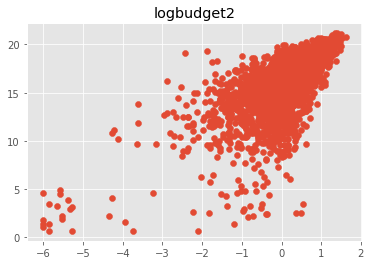

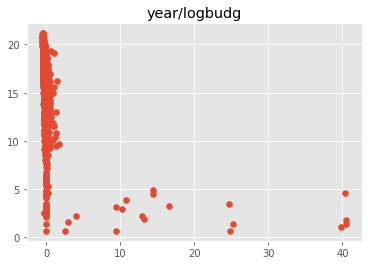

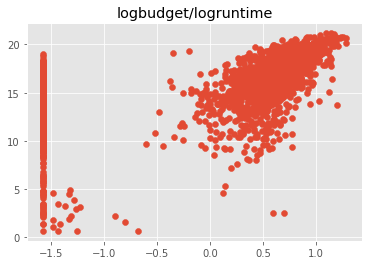

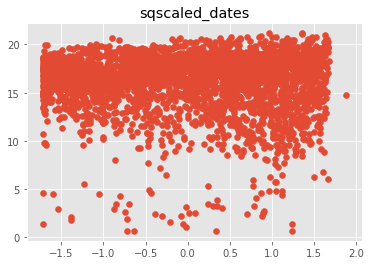

In [88]:
# Plot most important features
for i in [153, 158, 164, 83]:
    plt.scatter(pro_train2[pro_train.columns[i]], target)
    plt.title(pro_train.columns[i])
    plt.show()

In [89]:
# Find the weights for Ridge
rid = Ridge()
perm = PermutationImportance(rid, cv=5)
perm.fit(pro_train2.values, target)
eli5.show_weights(perm)


Weight,Feature
3.1348 ± 4.2050,x58
2.7790 ± 3.7364,x127
1.1603 ± 1.6483,x174
1.1390 ± 1.5763,x183
1.0440 ± 0.8183,x88
0.9785 ± 1.3265,x184
0.9585 ± 1.3058,x179
0.3081 ± 0.5961,x160
0.2658 ± 0.0747,x153
0.1865 ± 0.1396,x185


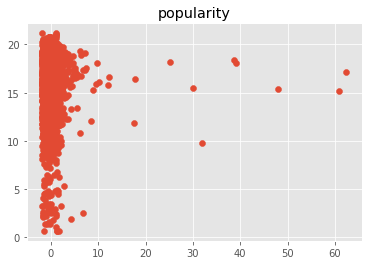

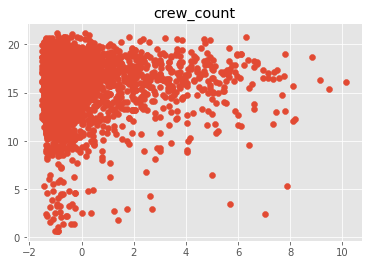

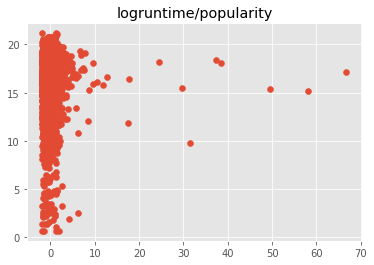

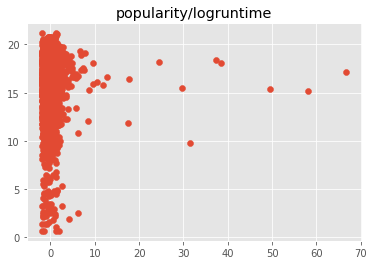

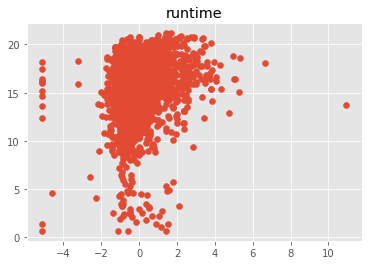

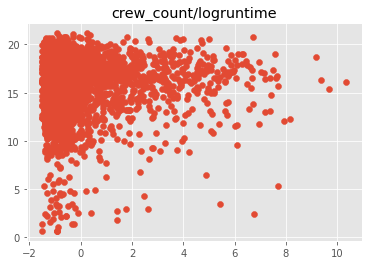

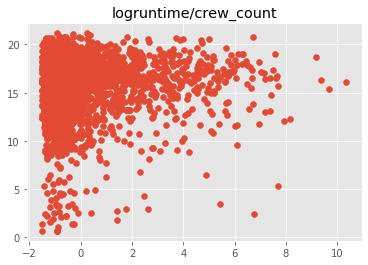

In [90]:
# Plot the importat features
for i in [58, 127, 183, 174, 88, 179, 184]:
    plt.scatter(pro_train2[pro_train2.columns[i]], target)
    plt.title(pro_train2.columns[i])
    plt.show()

# Modeling

In [91]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error

# Get tuned XGBRegressor
def tune_xgb(train=pro_train2.values,target=target,n_iters=1000):
    params ={
        'max_depth':range(3,10,2),
        'min_child_weight':range(1,6,2),
        'gamma':np.arange(0,.5,0.05),
        'subsample':np.arange(.6,1.0,.05),
        'colsample_bytree':np.arange(.6,1.0,.05),
        'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
        'n_estimators': [int(29.5* i ** 2) + 50 for i in range(10)]
    }
    xgbr = xgb.XGBRegressor()
    rs = RandomizedSearchCV(xgbr, params, n_iter=n_iters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    rs.fit(train,target)
    print(rs.best_score_, rs.best_params_)
    return rs.best_estimator_

In [92]:
# Get tuned LGBMRegressor
def tune_lgbm(train=pro_train2.values,target=target,n_iters=1000):
    params = {
        'n_estimators': [50, 100, 200, 400, 500, 800, 1000, 1500, 2000, 2500],
        'num_leaves': [15, 31, 63, 127],
        'subsample': [0.6, 0.7, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
        'num_leaves': list(range(8, 92, 4)),
        'min_data_in_leaf': [10, 20, 40, 60, 100],
        'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
        'learning_rate': [0.1, 0.05, 0.01, 0.005],
        'bagging_freq': [3, 4, 5, 6, 7],
        'bagging_fraction': np.linspace(0.6, 0.95, 10),
        'reg_alpha': np.linspace(0.1, 0.95, 10),
        'reg_lambda': np.linspace(0.1, 0.95, 10),
        'objective': ['huber'],
        'boosting': ['gbdt'],
        'verbosity': [1],
        'random_seed': [19],
        'metric': ['mae'],
        'bagging_seed': [11]
    }
    model = lgb.LGBMRegressor()
    rs = RandomizedSearchCV(model, params, n_iter=n_iters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    rs.fit(train,target)
    print(rs.best_score_, rs.best_params_)
    return rs.best_estimator_

In [94]:
from tqdm import tqdm
# Tune models
for f in tqdm([tune_xgb, tune_lgbm]):
    if f != tune_lgbm:
        xgbr = f()
    else:
        lgbmr = f()



  0%|          | 0/2 [00:00<?, ?it/s]

[21:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.




 50%|█████     | 1/2 [2:24:23<2:24:23, 8663.66s/it]

-3.745961067313923 {'subsample': 0.8500000000000002, 'reg_alpha': 0.01, 'n_estimators': 168, 'min_child_weight': 3, 'max_depth': 3, 'gamma': 0.25, 'colsample_bytree': 0.9500000000000003}




100%|██████████| 2/2 [3:09:54<00:00, 6883.95s/it]  

-3.6703512455426073 {'verbosity': 1, 'subsample': 0.6, 'reg_lambda': 0.47777777777777775, 'reg_alpha': 0.1, 'random_seed': 19, 'objective': 'huber', 'num_leaves': 84, 'n_estimators': 800, 'min_data_in_leaf': 10, 'metric': 'mae', 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'boosting': 'gbdt', 'bagging_seed': 11, 'bagging_freq': 4, 'bagging_fraction': 0.7944444444444444}


In [96]:
from sklearn.ensemble import VotingRegressor

#Get tuned voting regression ensamble
best_weights = []
best_score = 0
def tuneVote(n=100, xgbr=xgbr, lgbmr=lgbmr):
    for i in tqdm(range(n)):
        weights = np.random.random_sample((6,))
        weights = np.exp(weights)/sum(np.exp(weights))
        ens = VotingRegressor([('xgb', xgbr), ('lgbm', lgbmr), ('svr', SVR()),('ridge',Ridge()),
                                ('lasso', Lasso()), ('cat', cat.CatBoostRegressor())], weights=weights, n_jobs=-1)

        ens.fit(pro_train2.values, target)
        score = check_CV(pro_train2.values, target, ens)
        if i == 0 or best_score > score:
            best_weights = weights
            best_score = score
            print(i, best_score, weights)
    return  VotingRegressor([('xgb', xgb.XGBRegressor()), ('lgbm', lgb.LGBMRegressor()), ('svr', SVR()),('ridge',Ridge()),
                            ('lasso', Lasso()), ('cat', cat.CatBoostRegressor())], weights = best_weights, n_jobs=-1), best_weights, best_score
ens2, weights, score = tuneVote()
weights, score



  0%|          | 0/10 [00:00<?, ?it/s]/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 10%|█         | 1/10 [04:08<37:18, 248.71s/it]

0 2.039617755568367 [0.12265066 0.08945968 0.23798814 0.14258033 0.2195954  0.18772579]


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 20%|██        | 2/10 [08:11<32:54, 246.78s/it]

1 1.9815094534599607 [0.13965661 0.1602341  0.10712929 0.10835602 0.23950545 0.24511854]


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 30%|███       | 3/10 [12:09<28:30, 244.31s/it]/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 40%|████      | 4/10 [16:09<24:18, 243.08s/it]

3 1.9748150129436683 [0.11428137 0.24106358 0.09803482 0.11600925 0.23702618 0.1935848 ]


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 50%|█████     | 5/10 [20:

4 1.9674566101237931 [0.13582144 0.23368081 0.16040327 0.10196414 0.15092489 0.21720545]


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 60%|██████    | 6/10 [24:22<16:19, 244.85s/it]

5 1.9594612283520347 [0.20422698 0.17333745 0.14355025 0.19065237 0.15487506 0.13335789]


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 70%|███████   | 7/10 [28:20<12:07, 242.63s/it]

6 1.94682328480163 [0.10755858 0.24339557 0.14157908 0.17766768 0.11716648 0.21263261]


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 80%|████████  | 8/10 [32:13<07:59, 239.73s/it]/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



 90%|█████████ | 9/10 [36:18<04:01, 241.24s/it]/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. T

(array([0.10755858, 0.24339557, 0.14157908, 0.17766768, 0.11716648,
        0.21263261]), 1.94682328480163)

In [ ]:
# Show the weights of features
perm = PermutationImportance(ens2, cv=5)
perm.fit(pro_train2.values, target)
eli5.show_weights(perm)

In [ ]:
# Plot best features
for i in [149,154,18,82,57]:
    plt.scatter(pro_train2[pro_train2.columns[i]].values, target)
    plt.title(pro_train2.columns[i])
    plt.show()


In [ ]:
# Select important Features
sel = SelectFromModel(perm, threshold=0.001, prefit=True)
train_trans = sel.transform(pro_train2.values)
test_trans = sel.transform(pro_test2.values)
train_trans.shape

In [ ]:
# Train test set
ens2.fit(train_trans, target)
sub = pd.read_csv('sample_submission.csv')
sub['revenue'] = np.exp(ens2.predict(test_trans)) - 1
sub.to_csv('voting_newbudg_cat6.csv',index=False)